In [1]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Utils.recsys2022DataReader import *
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.KNN.ItemKNNCFRecommenderPLUS import ItemKNNCFRecommender
from Evaluation.Evaluator import EvaluatorHoldout
import matplotlib.pyplot as plt

In [2]:
URM = createURM()

/Users/matteopancini/PycharmProjects/recsys-challenge-2022-Pancini-Vitali/Utils/recsys2022DataReader.py:20: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(urmPath)


In [11]:
ICM = createSmallICM()

In [3]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM, train_percentage=0.85)

In [4]:
profile_length = np.ediff1d(URM.indptr)
sorted_users = np.argsort(profile_length)

In [5]:
block_size = int(len(profile_length) * 0.2)

In [6]:
interactions = []
for i in range(41629):
    interactions.append(len(URM[i,:].nonzero()[0]))

In [7]:
recommender_object_dict = {}

In [8]:
# RP3beta
RP3beta = RP3betaRecommender(URM_train)
RP3beta.fit(alpha=0.5126756776495514, beta=0.396119587486951, topK=100)
recommender_object_dict['RP3Beta'] = RP3beta

RP3betaRecommender: Similarity column 24507 (100.0%), 3707.68 column/sec. Elapsed time 6.61 sec


In [12]:
bestItemKNNCFG0 = ItemKNNCFRecommender(URM_train)
bestItemKNNCFG0.fit(ICM, shrink=50, topK=5893, similarity='rp3beta',
                    normalization='tfidf')
recommender_object_dict['bestItemKNNCFG0'] = bestItemKNNCFG0

Done: 100%|██████████| 24507/24507 [00:20<00:00, 1218.96it/s]            


In [15]:
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender

slimEN = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train)
slimEN.fit(alpha=0.009579327319679334, l1_ratio=0.3586486802592749, topK=159)
recommender_object_dict['slimEN'] = slimEN

100%|█████████▉| 24504/24507 [02:58<00:00, 137.30it/s]


# Interactions

In [16]:
list_group_interactions = [[0, 199], [200, max(interactions)]]
MAP_recommender_per_group_int = {}

for group_id in range(0, 2):
    lower_bound = list_group_interactions[group_id][0]
    higher_bound = list_group_interactions[group_id][1]

    users_in_group = [user_id for user_id in range(len(interactions))
                      if (lower_bound <= interactions[user_id] <= higher_bound)]
    users_in_group_p_len = profile_length[users_in_group]

    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id,
        len(users_in_group),
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group_int:
            MAP_recommender_per_group_int[label].append(result_df.loc[10]["MAP"])
        else:
            MAP_recommender_per_group_int[label] = [result_df.loc[10]["MAP"]]

Group 0, #users in group 41415, average p.len 35.97, median 29.0, min 5, max 199
EvaluatorHoldout: Ignoring 914 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 214 Users
EvaluatorHoldout: Processed 40501 (100.0%) in 18.00 sec. Users per second: 2250
EvaluatorHoldout: Processed 40501 (100.0%) in 45.10 sec. Users per second: 898
EvaluatorHoldout: Processed 40501 (100.0%) in 19.57 sec. Users per second: 2070
Group 1, #users in group 214, average p.len 303.56, median 254.5, min 200, max 1206
EvaluatorHoldout: Ignoring 914 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 41415 Users
EvaluatorHoldout: Processed 214 (100.0%) in 1.04 sec. Users per second: 205
EvaluatorHoldout: Processed 214 (100.0%) in 1.49 sec. Users per second: 144
EvaluatorHoldout: Processed 214 (100.0%) in 1.01 sec. Users per second: 213


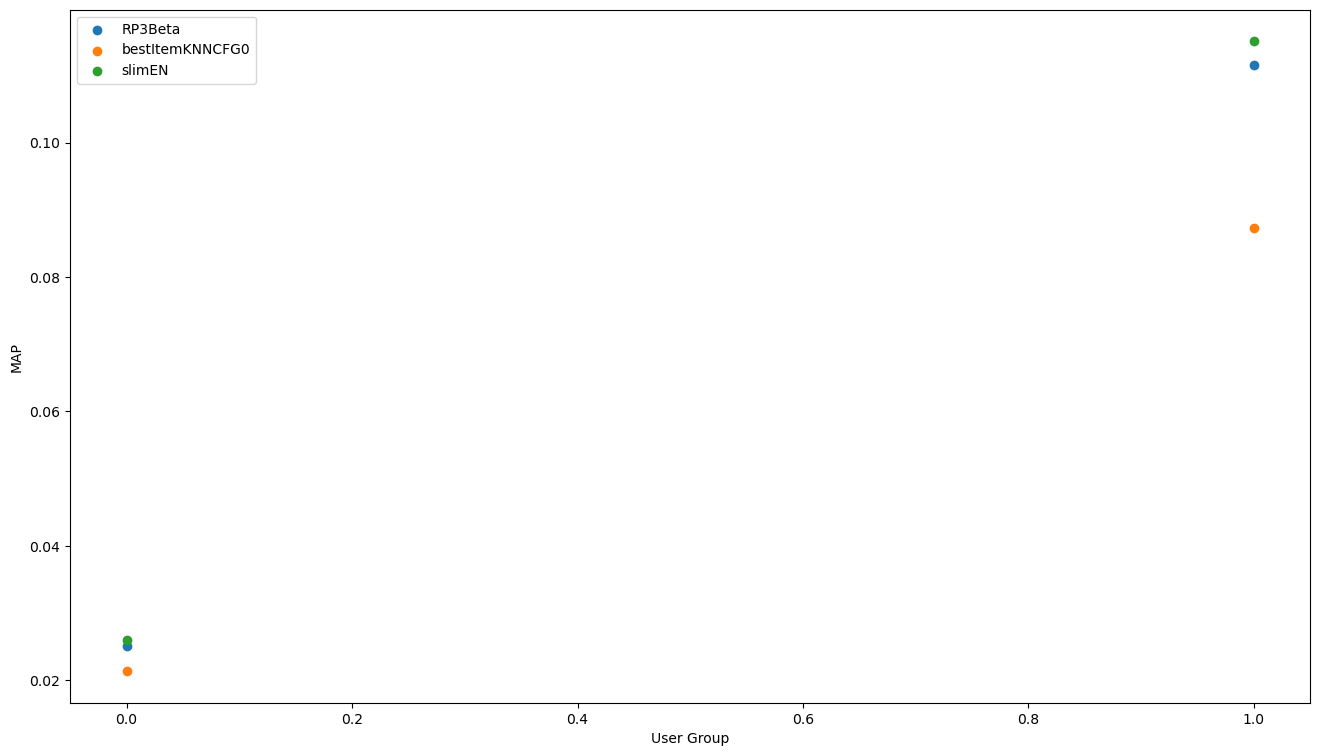

RP3Beta [0.02507093593221033, 0.11162661326212722]
bestItemKNNCFG0 [0.021349618841470346, 0.0872381694110666]
slimEN [0.026025460668616877, 0.11509846461949272]


In [17]:
_ = plt.figure(figsize=(16, 9))

finalResults = {}

for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group_int[label]
    finalResults[label] = results
    plt.scatter(x=np.arange(0, len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

for label in finalResults:
    print(label + ' ' + str(finalResults[label]))

# 2 Blocks

In [29]:
MAP_recommender_per_group_block = {}
block_size = int(len(profile_length) * 0.1)

for group_id in range(0, 10):
    start_pos = group_id * block_size
    end_pos = min((group_id + 1) * block_size, len(profile_length))

    users_in_group = sorted_users[start_pos:end_pos]

    users_in_group_p_len = profile_length[users_in_group]

    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id,
        len(users_in_group),
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group_block:
            MAP_recommender_per_group_block[label].append(result_df.loc[10]["MAP"])
        else:
            MAP_recommender_per_group_block[label] = [result_df.loc[10]["MAP"]]

Group 0, #users in group 4162, average p.len 14.60, median 15.0, min 5, max 17
EvaluatorHoldout: Ignoring 902 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 37467 Users
EvaluatorHoldout: Processed 3748 (100.0%) in 2.42 sec. Users per second: 1551
Group 1, #users in group 4162, average p.len 18.62, median 19.0, min 17, max 20
EvaluatorHoldout: Ignoring 902 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 37467 Users
EvaluatorHoldout: Processed 3975 (100.0%) in 2.53 sec. Users per second: 1573
Group 2, #users in group 4162, average p.len 21.33, median 21.0, min 20, max 23
EvaluatorHoldout: Ignoring 902 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 37467 Users
EvaluatorHoldout: Processed 4040 (100.0%) in 2.58 sec. Users per second: 1565
Group 3, #users in group 4162, average p.len 23.98, median 24.0, min 23, max 25
EvaluatorHoldout: Ignoring 902 ( 2.2%) Users that have less than 1 test int

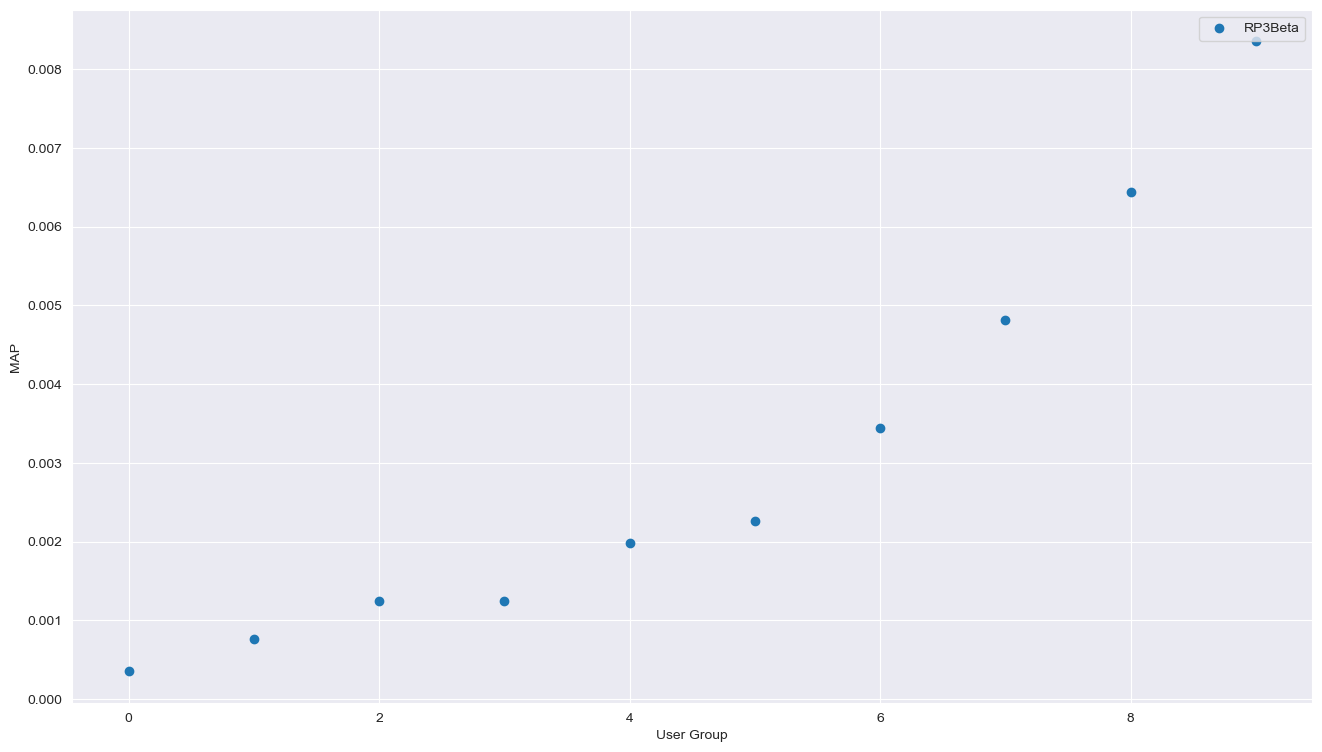

RP3Beta [0.0003541783130897325, 0.0007697214734950581, 0.0012513849599245627, 0.0012453328972828598, 0.001985651380253857, 0.0022614722808474287, 0.0034479388770433514, 0.004819276993477528, 0.006444459703291747, 0.008355214983638865]


In [30]:
_ = plt.figure(figsize=(16, 9))

finalResults = {}

for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group_block[label]
    finalResults[label] = results
    plt.scatter(x=np.arange(0, len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

for label in finalResults:
    print(label + ' ' + str(finalResults[label]))

# 4 blocks

In [18]:
MAP_recommender_per_group_block = {}
block_size = int(len(profile_length) * 0.25)

for group_id in range(0, 4):
    start_pos = group_id * block_size
    end_pos = min((group_id + 1) * block_size, len(profile_length))

    users_in_group = sorted_users[start_pos:end_pos]

    users_in_group_p_len = profile_length[users_in_group]

    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id,
        len(users_in_group),
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group_block:
            MAP_recommender_per_group_block[label].append(result_df.loc[10]["MAP"])
        else:
            MAP_recommender_per_group_block[label] = [result_df.loc[10]["MAP"]]

Group 0, #users in group 10407, average p.len 17.42, median 18.0, min 5, max 21
EvaluatorHoldout: Ignoring 914 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 31222 Users
EvaluatorHoldout: Processed 9709 (100.0%) in 4.83 sec. Users per second: 2010
EvaluatorHoldout: Processed 9709 (100.0%) in 9.84 sec. Users per second: 987
EvaluatorHoldout: Processed 9709 (100.0%) in 4.67 sec. Users per second: 2077
Group 1, #users in group 10407, average p.len 24.78, median 25.0, min 21, max 29
EvaluatorHoldout: Ignoring 914 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 31222 Users
EvaluatorHoldout: Processed 10239 (100.0%) in 5.05 sec. Users per second: 2029
EvaluatorHoldout: Processed 10239 (100.0%) in 11.27 sec. Users per second: 908
EvaluatorHoldout: Processed 10239 (100.0%) in 5.34 sec. Users per second: 1919
Group 2, #users in group 10407, average p.len 34.40, median 34.0, min 29, max 42
EvaluatorHoldout: Ignoring 914 ( 2.2%) U

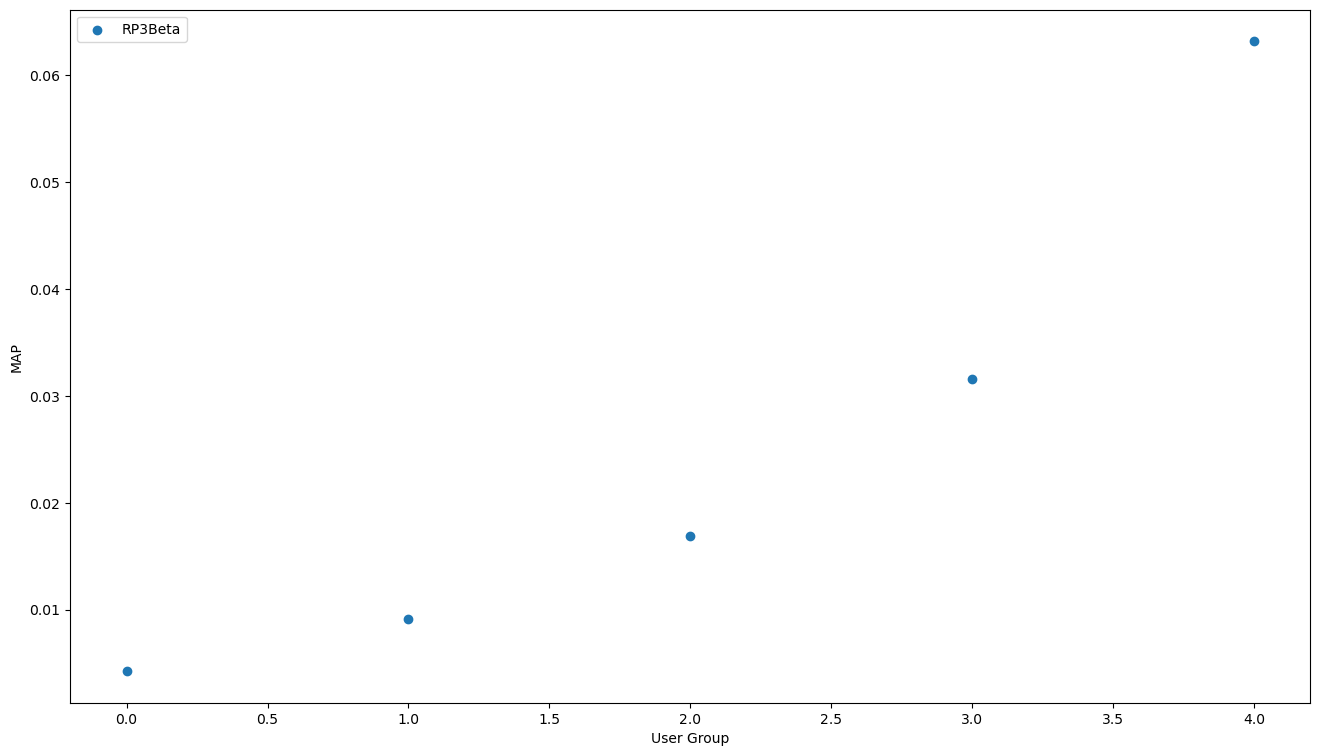

RP3Beta [0.004244502920725542, 0.009123291589044987, 0.016884521404521305, 0.031573308346084905, 0.06318031841365232]


In [14]:
_ = plt.figure(figsize=(16, 9))

finalResults = {}

for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group_block[label]
    finalResults[label] = results
    plt.scatter(x=np.arange(0, len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

for label in finalResults:
    print(label + ' ' + str(finalResults[label]))

# Interactions 2

In [25]:
list_group_interactions = [[0, 20], [21, max(interactions)]]
MAP_recommender_per_group_int = {}

for group_id in range(0, 2):
    lower_bound = list_group_interactions[group_id][0]
    higher_bound = list_group_interactions[group_id][1]

    users_in_group = [user_id for user_id in range(len(interactions))
                      if (lower_bound <= interactions[user_id] <= higher_bound)]
    users_in_group_p_len = profile_length[users_in_group]

    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id,
        len(users_in_group),
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group_int:
            MAP_recommender_per_group_int[label].append(result_df.loc[10]["MAP"])
        else:
            MAP_recommender_per_group_int[label] = [result_df.loc[10]["MAP"]]

Group 0, #users in group 9096, average p.len 16.90, median 17.0, min 5, max 20
EvaluatorHoldout: Ignoring 914 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 32533 Users
EvaluatorHoldout: Processed 8439 (100.0%) in 3.97 sec. Users per second: 2127
EvaluatorHoldout: Processed 8439 (100.0%) in 8.01 sec. Users per second: 1054
EvaluatorHoldout: Processed 8439 (100.0%) in 3.93 sec. Users per second: 2148
Group 1, #users in group 32533, average p.len 43.06, median 33.0, min 21, max 1206
EvaluatorHoldout: Ignoring 914 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 9096 Users
EvaluatorHoldout: Processed 32276 (100.0%) in 14.14 sec. Users per second: 2283
EvaluatorHoldout: Processed 32276 (100.0%) in 37.18 sec. Users per second: 868
EvaluatorHoldout: Processed 32276 (100.0%) in 15.59 sec. Users per second: 2071


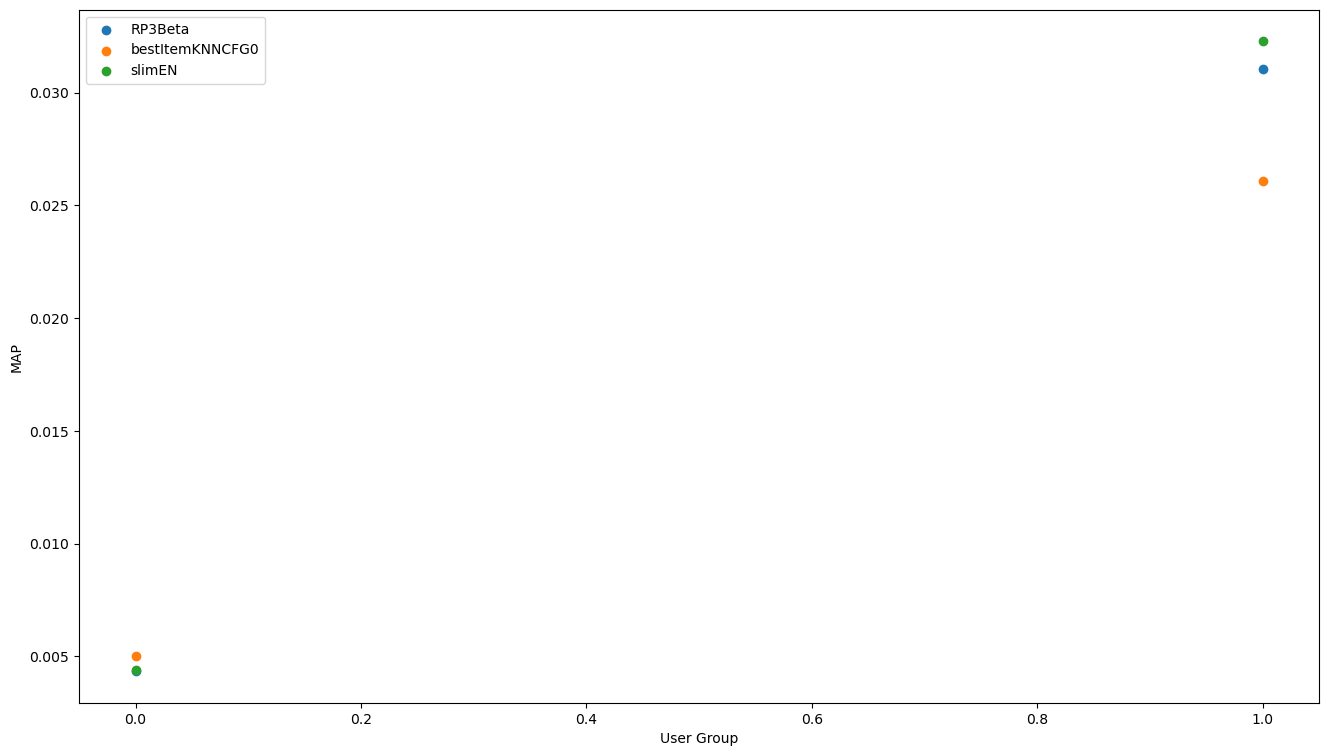

RP3Beta [0.0043421792621935, 0.031064643098119266]
bestItemKNNCFG0 [0.005008233692023252, 0.02605915840951104]
slimEN [0.004379694050863643, 0.03227562324553817]


In [26]:
_ = plt.figure(figsize=(16, 9))

finalResults = {}

for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group_int[label]
    finalResults[label] = results
    plt.scatter(x=np.arange(0, len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

for label in finalResults:
    print(label + ' ' + str(finalResults[label]))